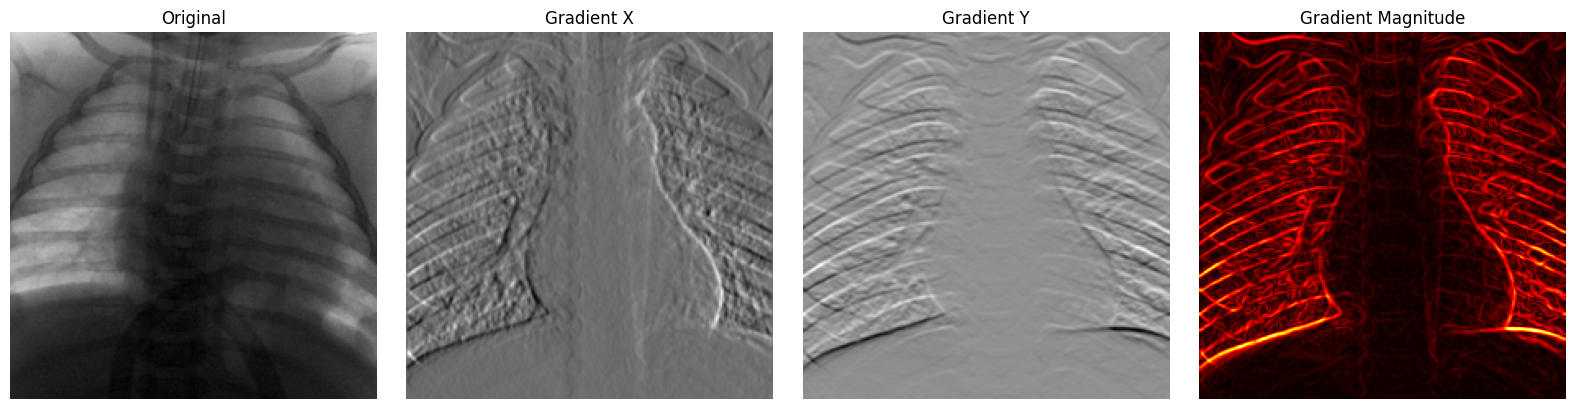

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# ---- Load and preprocess images ----

def load_images_from_folder(folder, image_size=(224, 224), max_images=None):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
            if max_images and i >= max_images:
                break
            img = Image.open(os.path.join(folder, filename)).convert('L')
            img = img.resize(image_size)
            images.append(np.array(img) / 255.0)
    return np.array(images)

# ---- Define Sobel kernels ----

SOBEL_X = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

SOBEL_Y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

# ---- Convolution function ----

def convolve(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad = kh // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
    return output

# ---- Gradient computation ----

def compute_gradients(image):
    grad_x = convolve(image, SOBEL_X)
    grad_y = convolve(image, SOBEL_Y)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x)
    return grad_x, grad_y, magnitude, orientation

# ---- Run on sample data ----

# Example: Replace with your actual path to training data
train_folder = "/Users/maximcrucirescu/Desktop/dtu notes/sem 6/math_modelling/githubvenv/Project 4/data - Copy/Train"

# Load a few sample images
images = load_images_from_folder(train_folder)

# Compute and visualize gradients for the first image
grad_x, grad_y, mag, ori = compute_gradients(images[0])

# ---- Visualize ----
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(images[100], cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(grad_x, cmap='gray')
axs[1].set_title('Gradient X')
axs[2].imshow(grad_y, cmap='gray')
axs[2].set_title('Gradient Y')
axs[3].imshow(mag, cmap='hot')
axs[3].set_title('Gradient Magnitude')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [9]:
def compute_magnitude_features(images):
    features = []
    for img in images:
        grad_x = convolve(img, SOBEL_X)
        grad_y = convolve(img, SOBEL_Y)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        features.append(magnitude.flatten())
    return np.array(features)


In [11]:
# Replace with actual paths
X_train_images = load_images_from_folder("data - Copy/Train")
X_test_images = load_images_from_folder("data - Copy/Test")

X_train = compute_magnitude_features(X_train_images)
X_test = compute_magnitude_features(X_test_images)

# Labels based on filenames (0 = healthy, 1 = pneumonia)
def extract_labels(folder):
    labels = []
    for fname in sorted(os.listdir(folder)):
        labels.append(1 if "positive" in fname.lower() else 0)
    return np.array(labels)

y_train = extract_labels("data - Copy/Train")
y_test = extract_labels("data - Copy/Test")


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lambdas = [0.01, 0.1, 1, 10]
results = []

for lam in lambdas:
    model = LogisticRegression(penalty='l2', C=1/lam, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((lam, acc, model))
    print(f"λ = {lam} → Accuracy: {acc:.4f}")


λ = 0.01 → Accuracy: 0.6042
λ = 0.1 → Accuracy: 0.6138
λ = 1 → Accuracy: 0.6122
λ = 10 → Accuracy: 0.6154


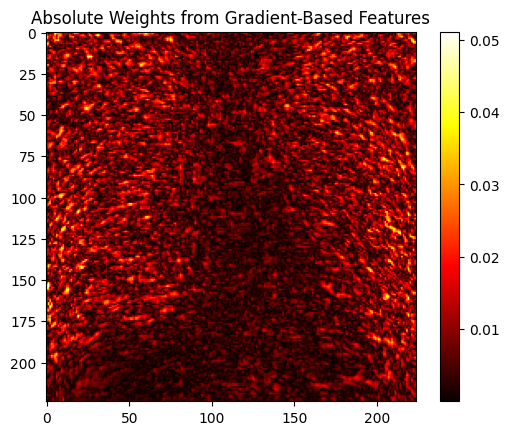

In [13]:
import matplotlib.pyplot as plt

# Pick best model
best_model = max(results, key=lambda x: x[1])[2]
best_weights = best_model.coef_.reshape(224, 224)

plt.imshow(np.abs(best_weights), cmap='hot')
plt.title('Absolute Weights from Gradient-Based Features')
plt.colorbar()
plt.show()
